# Greater-than

# Setup

In [1]:
from transcoder_circuits.circuit_analysis import *
from transcoder_circuits.feature_dashboards import *
from transcoder_circuits.replacement_ctx import *

In [2]:
from sae_training.sparse_autoencoder import SparseAutoencoder
from transformer_lens import HookedTransformer, utils
model = HookedTransformer.from_pretrained('gpt2')

Loaded pretrained model gpt2 into HookedTransformer


In [3]:
# This function was stolen from one of Neel Nanda's exploratory notebooks
# Thanks, Neel!
import einops
def tokenize_and_concatenate(
    dataset,
    tokenizer,
    streaming = False,
    max_length = 1024,
    column_name = "text",
    add_bos_token = True,
):
    """Helper function to tokenizer and concatenate a dataset of text. This converts the text to tokens, concatenates them (separated by EOS tokens) and then reshapes them into a 2D array of shape (____, sequence_length), dropping the last batch. Tokenizers are much faster if parallelised, so we chop the string into 20, feed it into the tokenizer, in parallel with padding, then remove padding at the end.

    This tokenization is useful for training language models, as it allows us to efficiently train on a large corpus of text of varying lengths (without, eg, a lot of truncation or padding). Further, for models with absolute positional encodings, this avoids privileging early tokens (eg, news articles often begin with CNN, and models may learn to use early positional encodings to predict these)

    Args:
        dataset (Dataset): The dataset to tokenize, assumed to be a HuggingFace text dataset.
        tokenizer (AutoTokenizer): The tokenizer. Assumed to have a bos_token_id and an eos_token_id.
        streaming (bool, optional): Whether the dataset is being streamed. If True, avoids using parallelism. Defaults to False.
        max_length (int, optional): The length of the context window of the sequence. Defaults to 1024.
        column_name (str, optional): The name of the text column in the dataset. Defaults to 'text'.
        add_bos_token (bool, optional): . Defaults to True.

    Returns:
        Dataset: Returns the tokenized dataset, as a dataset of tensors, with a single column called "tokens"

    Note: There is a bug when inputting very small datasets (eg, <1 batch per process) where it just outputs nothing. I'm not super sure why
    """
    for key in dataset.features:
        if key != column_name:
            dataset = dataset.remove_columns(key)

    if tokenizer.pad_token is None:
        # We add a padding token, purely to implement the tokenizer. This will be removed before inputting tokens to the model, so we do not need to increment d_vocab in the model.
        tokenizer.add_special_tokens({"pad_token": "<PAD>"})
    # Define the length to chop things up into - leaving space for a bos_token if required
    if add_bos_token:
        seq_len = max_length - 1
    else:
        seq_len = max_length

    def tokenize_function(examples):
        text = examples[column_name]
        # Concatenate it all into an enormous string, separated by eos_tokens
        full_text = tokenizer.eos_token.join(text)
        # Divide into 20 chunks of ~ equal length
        num_chunks = 20
        chunk_length = (len(full_text) - 1) // num_chunks + 1
        chunks = [
            full_text[i * chunk_length : (i + 1) * chunk_length]
            for i in range(num_chunks)
        ]
        # Tokenize the chunks in parallel. Uses NumPy because HuggingFace map doesn't want tensors returned
        tokens = tokenizer(chunks, return_tensors="np", padding=True)[
            "input_ids"
        ].flatten()
        # Drop padding tokens
        tokens = tokens[tokens != tokenizer.pad_token_id]
        num_tokens = len(tokens)
        num_batches = num_tokens // (seq_len)
        # Drop the final tokens if not enough to make a full sequence
        tokens = tokens[: seq_len * num_batches]
        tokens = einops.rearrange(
            tokens, "(batch seq) -> batch seq", batch=num_batches, seq=seq_len
        )
        if add_bos_token:
            prefix = np.full((num_batches, 1), tokenizer.bos_token_id)
            tokens = np.concatenate([prefix, tokens], axis=1)
        return {"tokens": tokens}

    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=[column_name],
    )
    #tokenized_dataset.set_format(type="torch", columns=["tokens"])
    return tokenized_dataset


In [4]:
from datasets import load_dataset
from huggingface_hub import HfApi

dataset = load_dataset('Skylion007/openwebtext', split='train', streaming=True)
dataset = dataset.shuffle(seed=42, buffer_size=10_000)
tokenized_owt = tokenize_and_concatenate(dataset, model.tokenizer, max_length=128, streaming=True)
tokenized_owt = tokenized_owt.shuffle(42)
tokenized_owt = tokenized_owt.take(12800*2)
owt_tokens = np.stack([x['tokens'] for x in tokenized_owt])

Token indices sequence length is longer than the specified maximum sequence length for this model (73252 > 1024). Running this sequence through the model will result in indexing errors


In [5]:
owt_tokens_torch = torch.from_numpy(owt_tokens).cuda()

In [ ]:
transcoder_template = "./gpt-2-small-transcoders/final_sparse_autoencoder_gpt2-small_blocks.{}.ln2.hook_normalized_24576"
transcoders = []
frequencies = []
for i in range(12):
    transcoders.append(SparseAutoencoder.load_from_pretrained(f"{transcoder_template.format(i)}.pt").eval())
    frequencies.append(torch.load(f"{transcoder_template.format(i)}_log_feature_sparsity.pt"))

In [ ]:
# Clean up memory
import gc
gc.collect()
torch.cuda.empty_cache()

# Exploratory circuit analysis


We'll perform circuit analysis on the prompt "The war lasted from 1735 to 17". To perform our circuit analysis, we'll make a feature vector corresponding to the logit difference between predicting the token `40` and predicting the token `20`.

In [24]:
def make_one_hot(n, k):
    x = torch.zeros(n).to(device="cuda", dtype=torch.float32)
    x[k] = 1.0
    return x

In [52]:
with torch.no_grad():
    x = make_one_hot(model.W_U.shape[1], model.to_single_token('40'))\
        -make_one_hot(model.W_U.shape[1], model.to_single_token('20'))
    x = model.W_U @ x
feature_vector = FeatureVector(component_path=[Component(layer=len(model.blocks)-1, component_type=ComponentType.MLP, token=-1)], vector=x, layer=len(model.blocks)-1, sublayer="resid_post", token=-1)

### Getting top computational paths

Now that we have a `FeatureVector` object, let's find the computational paths in the model that are most important for causing this feature vector to activate on this input. To do this, we'll use the function `greedy_get_top_paths()`.

In [53]:
prompt = "The war lasted from 1735 to 17"
_, cache = model.run_with_cache(prompt) # cache the model activations on this prompt

all_paths = greedy_get_top_paths(model, transcoders, cache, feature_vector, num_iters=3, num_branches=15, do_raw_attribution=True)

In [54]:
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: mlp11@-1 <- mlp10tc[21238]@8: 1.6e+01
Path [0][1]: mlp11@-1 <- attn9[1]@6: 6.9
Path [0][2]: mlp11@-1 <- mlp10tc[9647]@8: 5.9
Path [0][3]: mlp11@-1 <- mlp9tc[12072]@8: 5.6
Path [0][4]: mlp11@-1 <- attn7[10]@6: 5.4
Path [0][5]: mlp11@-1 <- mlp10tc[10437]@8: 3.7
Path [0][6]: mlp11@-1 <- mlp9tc[3161]@8: 3.5
Path [0][7]: mlp11@-1 <- mlp9tc[20046]@8: 2.9
Path [0][8]: mlp11@-1 <- attn8[11]@6: 2.8
Path [0][9]: mlp11@-1 <- mlp9tc[4283]@8: 2.6
Path [0][10]: mlp11@-1 <- attn10[2]@6: 2.4
Path [0][11]: mlp11@-1 <- mlp10tc[3413]@8: 2.3
Path [0][12]: mlp11@-1 <- mlp8tc[15542]@8: 2.3
Path [0][13]: mlp11@-1 <- mlp9tc[1167]@8: 2.1
Path [0][14]: mlp11@-1 <- mlp9tc[11883]@8: 2.0
--- Paths of size 3 ---
Path [1][0]: mlp11@-1 <- attn9[1]@6: 6.9 <- mlp0tc[17180]@6: 4.7
Path [1][1]: mlp11@-1 <- mlp10tc[21238]@8: 1.6e+01 <- attn9[1]@6: 3.1
Path [1][2]: mlp11@-1 <- mlp10tc[9647]@8: 5.9 <- attn9[1]@6: 2.9
Path [1][3]: mlp11@-1 <- mlp10tc[9647]@8: 5.9 <- attn7[10]@6: 2.4
Path 

Looks like `mlp10tc[21238]@8: 1.8e+01` is responsible for mapping the information from the `35` token to the `40`-`20` logit vector. `mlp10tc[9647]` is also important.

We can see that the `tc0[17180]@35` contributes to the logits through attention head 1 in layer 9. What are the de-embeddings of this transcoder feature? 

In [83]:
display_deembeddings_for_transcoder_feature(model, transcoders[0], 17180)

Very sensible!

Let's do another prompt.

In [76]:
prompt = "The war lasted from 1527 to 15"
_, cache = model.run_with_cache(prompt) # cache the model activations on this prompt

all_paths = greedy_get_top_paths(model, transcoders, cache, feature_vector, num_iters=3, num_branches=15, do_raw_attribution=True)
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: mlp11@-1 <- mlp10tc[21238]@8: 1.1e+01
Path [0][1]: mlp11@-1 <- mlp10tc[10437]@8: 1.1e+01
Path [0][2]: mlp11@-1 <- mlp9tc[11883]@8: 5.3
Path [0][3]: mlp11@-1 <- mlp9tc[12072]@8: 5.2
Path [0][4]: mlp11@-1 <- attn9[1]@6: 3.3
Path [0][5]: mlp11@-1 <- mlp10tc[3413]@8: 3.0
Path [0][6]: mlp11@-1 <- mlp10tc[12424]@8: 2.5
Path [0][7]: mlp11@-1 <- mlp9tc[20046]@8: 2.5
Path [0][8]: mlp11@-1 <- mlp9tc[4283]@8: 2.5
Path [0][9]: mlp11@-1 <- mlp10tc[20856]@8: 2.4
Path [0][10]: mlp11@-1 <- mlp8tc[15542]@8: 2.1
Path [0][11]: mlp11@-1 <- mlp9tc[3161]@8: 1.7
Path [0][12]: mlp11@-1 <- attn8[6]@6: 1.6
Path [0][13]: mlp11@-1 <- attn8[10]@6: 1.5
Path [0][14]: mlp11@-1 <- mlp10tc[5315]@8: 1.4
--- Paths of size 3 ---
Path [1][0]: mlp11@-1 <- mlp10tc[21238]@8: 1.1e+01 <- attn9[1]@6: 2.3
Path [1][1]: mlp11@-1 <- mlp9tc[11883]@8: 5.3 <- attn9[1]@6: 2.2
Path [1][2]: mlp11@-1 <- mlp10tc[10437]@8: 1.1e+01 <- mlp9tc[11883]@8: 1.9
Path [1][3]: mlp11@-1 <- mlp10tc[10437]@8: 1.1e+01 

Now, we have another MLP10 feature: `mlp10tc[10437]@8: 1.1e+01`. And yet again, we see contributions to this feature through attention head 1 in layer 9 (e.g. `Path [2][1]: mlp11@-1 <- mlp10tc[10437]@8: 1.1e+01 <- attn9[1]@6: 1.8 <- mlp0tc[14599]@6: 1.1`). This corroborates what is seen in the original greater-than paper.

# Feature-level analysis

In [6]:
transcoder_template = "./gpt-2-small-transcoders/final_sparse_autoencoder_gpt2-small_blocks.{}.ln2.hook_normalized_24576"
tc10 = SparseAutoencoder.load_from_pretrained(f"{transcoder_template.format(10)}.pt").eval()

In [7]:
transcoder_template = "./gpt-2-small-transcoders/final_sparse_autoencoder_gpt2-small_blocks.{}.ln2.hook_normalized_24576"
tc0 = SparseAutoencoder.load_from_pretrained(f"{transcoder_template.format(0)}.pt").eval()

In [8]:
# Clean up memory
import gc
gc.collect()
torch.cuda.empty_cache()

Get MLP10 transcoder feature activations on all prompts.

In [9]:
prompts = [f"The war lasted from 17{i:02} to 17" for i in range(100)]
all_activs = []
with torch.no_grad():
    for prompt in prompts:
        _, cache = model.run_with_cache(prompt) # cache the model activations on this prompt
        feature_activs = tc10(cache[utils.get_act_name('normalized', 10, 'ln2')][:,-1])[1]
        all_activs.append(feature_activs)

Find the features with the greatest variance in activation strength over the prompts.

In [10]:
activs_tensor = torch.stack(all_activs)[:,0,:]
top_features = torch.topk(torch.var(activs_tensor, dim=0), k=10).indices

Now, do the same for MLP10 neurons.

In [11]:
mlp_activs = []
with torch.no_grad():
    for prompt in prompts:
        _, cache = model.run_with_cache(prompt) # cache the model activations on this prompt
        feature_activs = cache[utils.get_act_name('post', 10, 'mlp')][:,-1]
        mlp_activs.append(feature_activs)
mlp_activs = torch.stack(mlp_activs)[:,0,:]

In [12]:
top_neurons = torch.topk(torch.var(mlp_activs, dim=0), k=10).indices

## Logit-lens plots

Define a function for plotting the effect of an MLP10 transcoder feature on each `YY` token, along with the (scaled to fit in the plot) de-embedding score of each `YY` token.

De-embedding scores are calculated here as follows:
* First, look at the `feature_k` MLP0 transcoder features with the highest input-invariant connections to the MLP10 transcoder feature through the OV circuit of layer 9 attention head 1.
* Then, over these top MLP0 transcoder features, sum up the de-embedding scores of each `YY` token from the MLP0 transcoder feature, weighting it by the input-invariant connection strength between the MLP0 transcoder feature and the MLP10 transcoder feature.

In [43]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'stix'

def plot_feature_info(feature_idx, feature_k=1, is_mlp=False):
    years_list = []
    vec = tc10.W_enc[:, feature_idx] if not is_mlp else model.blocks[10].mlp.W_in[:, feature_idx].data
    top_mlp0_vals, top_mlp0_features = torch.topk(tc0.W_dec @ model.OV[9, 1] @ vec, k=feature_k)
    deembedding = torch.zeros(100).cuda()
    for v, f in zip(top_mlp0_vals, top_mlp0_features):
        deembedding = deembedding + (v * model.W_E @ tc0.W_enc[:, f.item()])[[model.to_single_token(f'{i:02}') for i in range(100)]]

    plt.title(f"Logits boosted by {'transcoder' if not is_mlp else 'MLP'} feature {feature_idx}")
    plt.xlabel("Year token")
    plt.ylabel("Logit increase")
    feature_logits = (tc10.W_dec[feature_idx] if not is_mlp else model.blocks[10].mlp.W_out[feature_idx].data) @ model.W_U
    xs = [feature_logits[model.to_single_token(f'{i:02}')].item() for i in range(100)]
    plt.plot(xs, marker='o', label='Logit increase')
    
    deembedding = utils.to_numpy(deembedding)
    de_min, de_max = deembedding.min(), deembedding.max()
    deembedding = (deembedding-de_min)/(de_max-de_min) * (np.max(xs) - np.min(xs)) + np.min(xs)
    plt.plot(deembedding, marker='o', label='Normalized de-embedding score', alpha=0.5)
    plt.legend()
    plt.show()

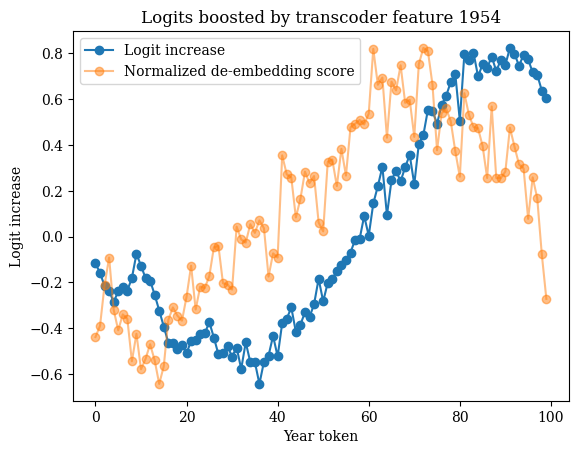

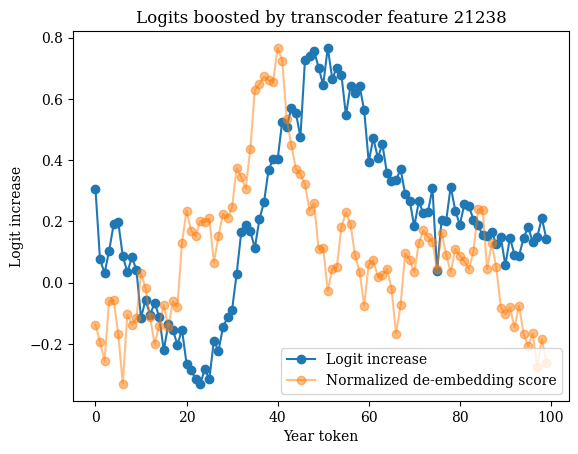

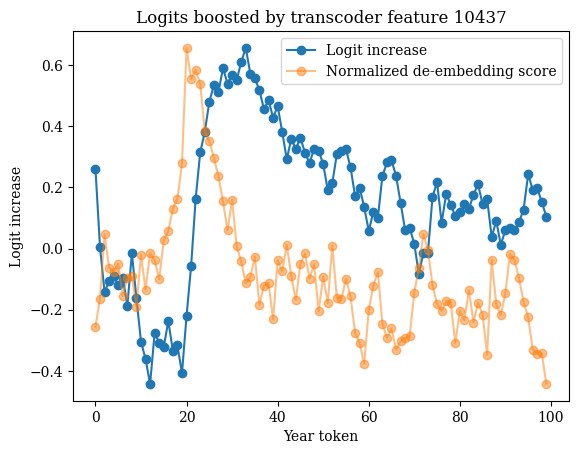

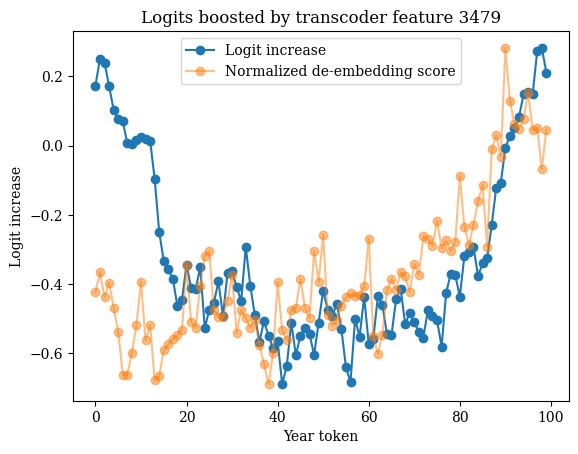

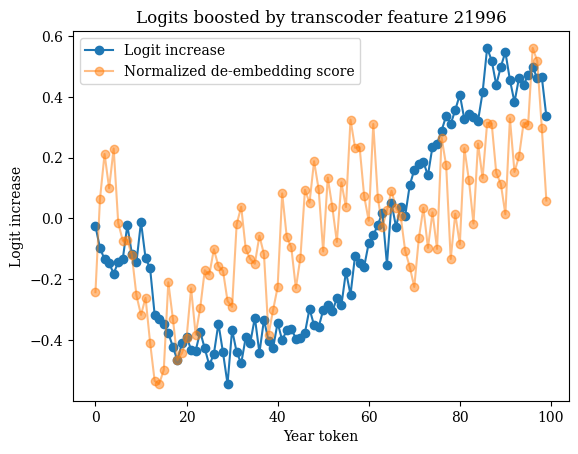

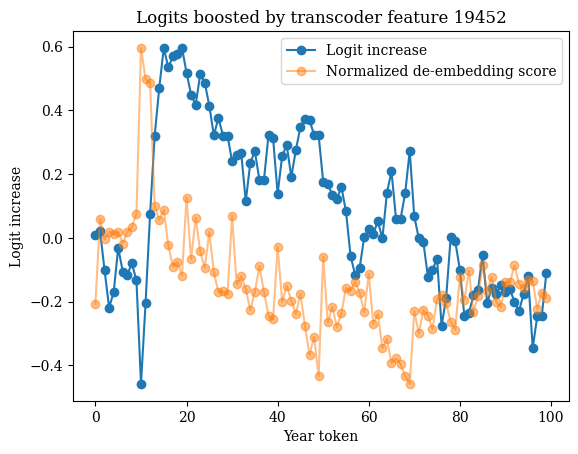

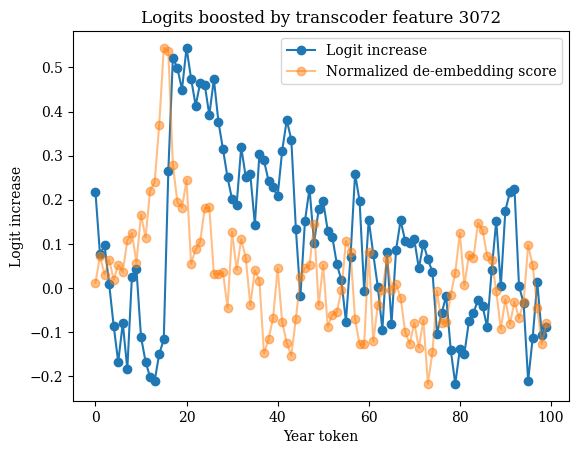

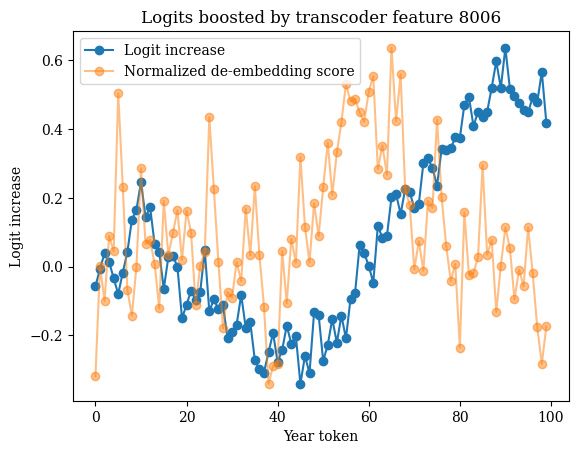

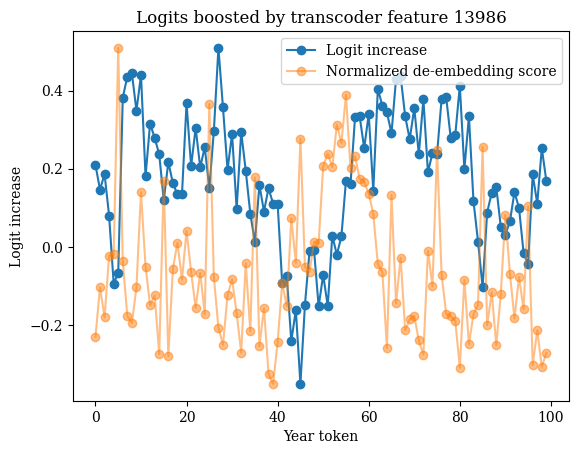

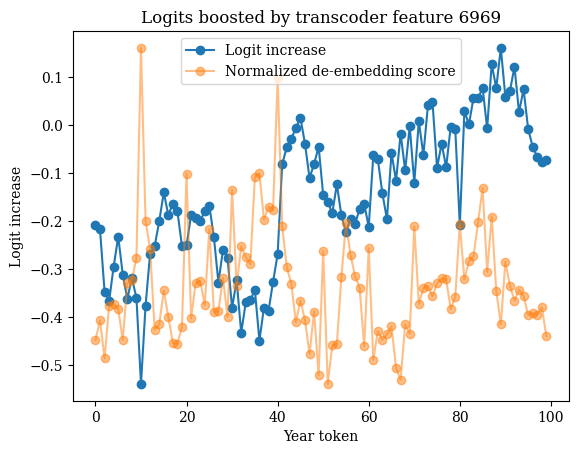

In [44]:
for i in range(10):
    plot_feature_info(top_features[i], feature_k=10)

## Evaluating feature performance versus neuron performance

Get original model performance.

In [40]:
logits = model(prompts, return_type='logits')[:, -1, [model.to_single_token(f'{i:02}') for i in range(100)]]

In [44]:
diffs = []
probs = torch.softmax(logits, dim=1)
for i in range(1,99):
    diffs.append((probs[i, i+1:].sum() - probs[i, :i+1].sum()).item())
np.mean(diffs)

0.8829426078163848

Get performance for different numbers of MLP neurons or transcoder features.

In [46]:
@torch.no_grad()
def eval_mlp_on_num(num, features_to_use, do_original=True):
    original_single_diff = None
    original_total_diff = None
    kld = None
    
    def mlp_replacement(acts, hook):
        new_acts = torch.zeros(acts.shape, dtype=acts.dtype).cuda()
        new_acts[:, :, features_to_use] = acts[:, :, features_to_use]
        return new_acts

    if type(num) == int:
        cur_prompts = [prompts[num]]
    elif type(num) == list:
        cur_prompts = [prompts[i] for i in num]
        num = torch.tensor(num).cuda()
    
    logitsA = model.run_with_hooks(cur_prompts, return_type="logits", fwd_hooks=[(utils.get_act_name('post', 10, 'mlp'), mlp_replacement)])
    logitsA = logitsA[:, -1, [model.to_single_token(f'{i:02}') for i in range(100)]]
    probsA = torch.softmax(logitsA, dim=-1)

    if do_original:
        logitsB = model(cur_prompts, return_type='logits')[:, -1, [model.to_single_token(f'{i:02}') for i in range(100)]]
        probsB = torch.softmax(logitsB, dim=-1)
    
        kld = torch.nn.functional.kl_div(torch.nn.functional.log_softmax(logitsA, dim=-1), probsB, reduction='batchmean')
        original_single_diff = probsB[:, num+1]-probsB[:, num-1]
    new_single_diff = probsA[:, num+1]-probsA[:, num-1]

    if type(num) == int:
        new_total_diff = probsA[:, num+1:].sum(dim=-1)-probsA[:, :num+1].sum(dim=-1)
        if do_original: original_total_diff = probsB[:, num+1:].sum(dim=-1)-probsB[:, :num+1].sum(dim=-1)
    else:
        new_single_diff = torch.diagonal(new_single_diff).mean()
        if do_original: original_single_diff = torch.diagonal(original_single_diff).mean()
        
        new_total_diff = []
        if do_original: original_total_diff = []
        for cur_num in num:
            new_total_diff.append(probsA[:, cur_num+1:].sum(dim=-1)-probsA[:, :cur_num+1].sum(dim=-1))
            if do_original: original_total_diff.append(probsB[:, cur_num+1:].sum(dim=-1)-probsB[:, :cur_num+1].sum(dim=-1))

        new_total_diff = torch.diagonal(torch.stack(new_total_diff)).mean()
        if do_original: original_total_diff = torch.diagonal(torch.stack(original_total_diff)).mean()

    return {
        'kld': kld,
        'new_single_diff': new_single_diff,
        'original_single_diff': original_single_diff,
        'new_total_diff': new_total_diff,
        'original_total_diff': original_total_diff,
    }

In [47]:
@torch.no_grad()
def eval_tc_on_num(num, features_to_use, do_original=True):
    original_single_diff = None
    original_total_diff = None
    kld = None

    class TCReplacementModule(torch.nn.Module):
        def forward(self, x):
            feature_acts = tc10(x)[1]
            feature_acts = feature_acts[:, :, features_to_use]
            W_dec = tc10.W_dec[features_to_use, :]
            tc_out = torch.einsum('btf, fd -> btd', feature_acts, W_dec)
            tc_out = tc_out + tc10.b_dec_out
            return tc_out

    if type(num) == int:
        cur_prompts = [prompts[num]]
    elif type(num) == list:
        cur_prompts = [prompts[i] for i in num]
        num = torch.tensor(num).cuda()

    original_mlp = model.blocks[10].mlp
    try:
        model.blocks[10].mlp = TCReplacementModule()
        logitsA = model(cur_prompts, return_type="logits")
    finally:
        model.blocks[10].mlp = original_mlp
    logitsA = logitsA[:, -1, [model.to_single_token(f'{i:02}') for i in range(100)]]
    probsA = torch.softmax(logitsA, dim=-1)

    if do_original:
        logitsB = model(cur_prompts, return_type='logits')[:, -1, [model.to_single_token(f'{i:02}') for i in range(100)]]
        probsB = torch.softmax(logitsB, dim=-1)
    
        kld = torch.nn.functional.kl_div(torch.nn.functional.log_softmax(logitsA, dim=-1), probsB, reduction='batchmean')
        original_single_diff = probsB[:, num+1]-probsB[:, num-1]
    new_single_diff = probsA[:, num+1]-probsA[:, num-1]

    if type(num) == int:
        new_total_diff = probsA[:, num+1:].sum(dim=-1)-probsA[:, :num+1].sum(dim=-1)
        if do_original: original_total_diff = probsB[:, num+1:].sum(dim=-1)-probsB[:, :num+1].sum(dim=-1)
    else:
        new_single_diff = torch.diagonal(new_single_diff).mean()
        if do_original: original_single_diff = torch.diagonal(original_single_diff).mean()
        
        new_total_diff = []
        if do_original: original_total_diff = []
        for cur_num in num:
            new_total_diff.append(probsA[:, cur_num+1:].sum(dim=-1)-probsA[:, :cur_num+1].sum(dim=-1))
            if do_original: original_total_diff.append(probsB[:, cur_num+1:].sum(dim=-1)-probsB[:, :cur_num+1].sum(dim=-1))

        new_total_diff = torch.diagonal(torch.stack(new_total_diff)).mean()
        if do_original: original_total_diff = torch.diagonal(torch.stack(original_total_diff)).mean()

    return {
        'kld': kld,
        'new_single_diff': new_single_diff,
        'original_single_diff': original_single_diff,
        'new_total_diff': new_total_diff,
        'original_total_diff': original_total_diff,
    }

In [48]:
import tqdm
def eval_mlp_features(k, dict_key='new_total_diff'):
    top_features = torch.topk(torch.var(mlp_activs, dim=0), k=k).indices
    ys = []
    for i in tqdm.tqdm(range(k)):
        ys.append(eval_mlp_on_num(list(range(1,99)), top_features[:i], do_original=False)[dict_key].item())
    return ys

In [49]:
import tqdm
def eval_tc_features(k, dict_key='new_total_diff', exclude_feature=None):
    top_features = torch.topk(torch.var(activs_tensor, dim=0), k=k).indices
    ys = []
    for i in tqdm.tqdm(range(k)):
        features = top_features[:i]
        if exclude_feature is not None:
            features = features[features != exclude_feature]
        ys.append(eval_tc_on_num(list(range(1,99)), features, do_original=False)[dict_key].item())
    return ys

In [48]:
tc_eval = eval_tc_features(100)
mlp_eval = eval_mlp_features(100)

100%|██████████| 100/100 [00:04<00:00, 21.95it/s]


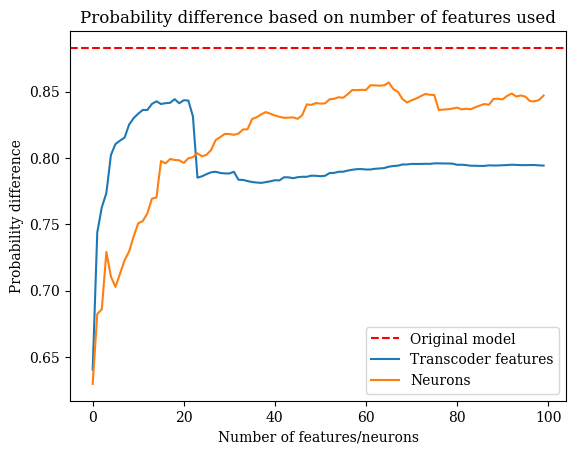

In [150]:
plt.title('Probability difference based on number of features used')
plt.axhline([0.8829426078163848], label='Original model', color='red', linestyle='dashed')
plt.plot(tc_eval, label='Transcoder features')
plt.plot(mlp_eval, label='Neurons')
plt.xlabel('Number of features/neurons')
plt.ylabel('Probability difference')
plt.legend()
plt.show()

In [156]:
np.argmin(np.abs(np.array(tc_eval)-np.array(mlp_eval))[1:])

24

# Looking at inaccuracy

What's with the dip in transcoder features around feature number 20?

In [50]:
tc_eval = eval_tc_features(100)

100%|██████████| 100/100 [00:05<00:00, 18.37it/s]


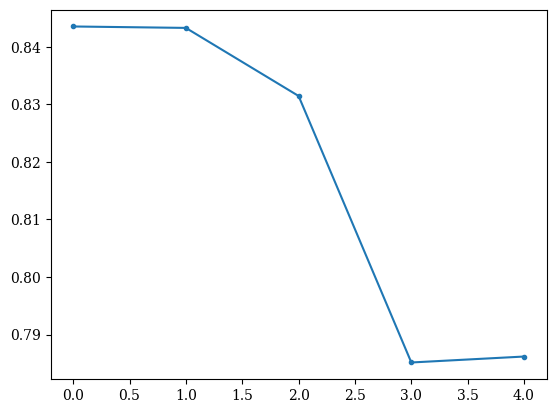

In [51]:
plt.plot(tc_eval[20:25], marker='.')

In [52]:
np.argmin(np.diff(tc_eval))

22

In [53]:
tc_eval[20:25]

[0.8435162901878357,
 0.8432683944702148,
 0.8314465880393982,
 0.7851703763008118,
 0.786202073097229]

So the drop happens when we use 23 transcoder features. This means that the feature with zero-index 22 is the one causing this drop.

In [54]:
torch.topk(torch.var(activs_tensor, dim=0), k=23).indices[22]

tensor(5315, device='cuda:0')

Feature 5315 is the culprit. What does its logit lens show?

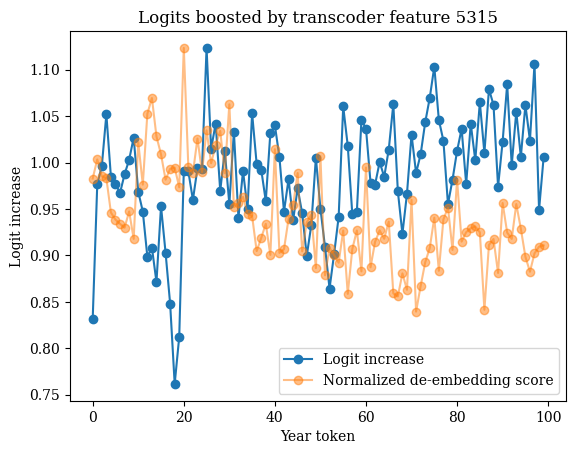

In [39]:
plot_feature_info(5315, feature_k=10)

Now, let's evaluate what happens if we ignore the bad transcoder feature in our analyis.

In [57]:
tc_eval = eval_tc_features(100)
mlp_eval = eval_mlp_features(100)

100%|██████████| 100/100 [00:05<00:00, 19.29it/s]


In [55]:
tc_eval_new = eval_tc_features(100, exclude_feature=5315)

100%|██████████| 100/100 [00:05<00:00, 18.22it/s]


In [71]:
# Evaluate performance of transcoder with all features
prob_diffs = []
with torch.no_grad():
    with TranscoderReplacementContext(model, [tc10]):
        for i in range(1,99):
            prompt = prompts[i]
            logits = model(prompt, return_type='logits')
            probs = torch.nn.functional.softmax(logits[0, -1, [model.to_single_token(f'{i:02}') for i in range(100)]], dim=-1)
            prob_diffs.append((probs[i+1:].sum()-probs[:i+1].sum()).item())
prob_diffs = np.array(prob_diffs)
prob_diffs.mean()

0.7978020669246206

In [72]:
# Evaluate performance of transcoder with all features except bad feature
features = torch.arange(tc10.W_enc.shape[1])
features = features[features != 5315]
y = eval_tc_on_num(list(range(1,99)), features, do_original=False)['new_total_diff'].item()
y

0.8453089594841003

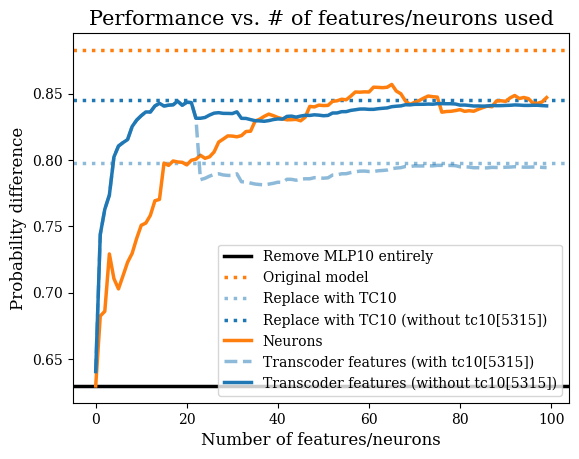

In [70]:
old_linewidth = plt.rcParams['lines.linewidth']
plt.rcParams['lines.linewidth'] = 2.5

plt.title('Performance vs. # of features/neurons used', fontsize=15)

plt.axhline(np.min(mlp_eval), label='Remove MLP10 entirely', color='black')
plt.axhline([0.8829426078163848], label='Original model', color='C1', linestyle='dotted')
plt.axhline([0.7978020669246206], label='Replace with TC10', color='C0', linestyle='dotted', alpha=0.5)
plt.axhline([0.8453089594841003], label='Replace with TC10 (without tc10[5315])', color='C0', linestyle='dotted')

plt.plot(mlp_eval, label='Neurons', color='C1')
plt.plot(tc_eval, label='Transcoder features (with tc10[5315])', color='C0', linestyle='dashed', alpha=0.5)
plt.plot(tc_eval_new, label='Transcoder features (without tc10[5315])', color='C0')

plt.xlabel('Number of features/neurons', fontsize=12)
plt.ylabel('Probability difference', fontsize=12)
plt.legend()
plt.show()

plt.rcParams['lines.linewidth'] = old_linewidth